In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from cv2 import aruco
from cv2 import VideoCapture
import json5


In [2]:
DATA_ROOT = "/mnt/e/Workspace/CathederTelesurgery/Data/Videos/2024-6-28"
CAMERA_EXTRINSIC_FILE = f"{DATA_ROOT}/cam3.json"

class CameraIntrinsics:
    def __init__(self, matrix, distorsion):
        self.matrix = matrix
        self.distorsion = distorsion
    @classmethod
    def from_file(clazz, matlab_calib_file):
        with open(matlab_calib_file, 'r') as f:
            intrinsics = json5.load(f)['Intrinsics']
            matrix = [[intrinsics['FocalLength'][0], intrinsics['Skew'], intrinsics['PrincipalPoint'][0]],[0, intrinsics['FocalLength'][1], intrinsics['PrincipalPoint'][1]],[0, 0, 1]]
            distorsion = [intrinsics['RadialDistortion'][0], intrinsics['RadialDistortion'][1], 0, intrinsics['TangentialDistortion'][0], intrinsics['TangentialDistortion'][1]]
            print(f"Camera intrinsics loaded from {matlab_calib_file} with matrix {matrix} and distorsion {distorsion}")
            return clazz(np.array(matrix), np.array(distorsion))

camera_intrinsics = CameraIntrinsics.from_file(CAMERA_EXTRINSIC_FILE)

Camera intrinsics loaded from /mnt/e/Workspace/CathederTelesurgery/Data/Videos/2024-6-28/cam3.json with matrix [[1432.3535332200738, 0, 960.2200313693709], [0, 1429.1723905623064, 559.2987936897417], [0, 0, 1]] and distorsion [0.05127226330669162, -0.11659145397355779, 0, 0, 0]


In [71]:

def aruco_single(img, pattern=aruco.DICT_5X5_250, camera_intrinsics=CameraIntrinsics(None, None)):
    result_img = img.copy()
    pattern = aruco.getPredefinedDictionary(pattern)
    params = aruco.DetectorParameters_create()
    corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(img, pattern, parameters=params)
    if ids is not None:
        rvecs, tvecs, _ = aruco.estimatePoseSingleMarkers(corners, 0.05, camera_intrinsics.matrix, camera_intrinsics.distorsion)
        for i in range(len(ids)):
            result_img = aruco.drawDetectedMarkers(result_img, corners, ids)
            for i in range(len(ids)):
                result_img = cv2.drawFrameAxes(result_img, camera_intrinsics.matrix, camera_intrinsics.distorsion, rvecs[i,:,:], tvecs[i,:,:], 0.1)
        return result_img, corners, ids, rvecs, tvecs
    return [None]*5


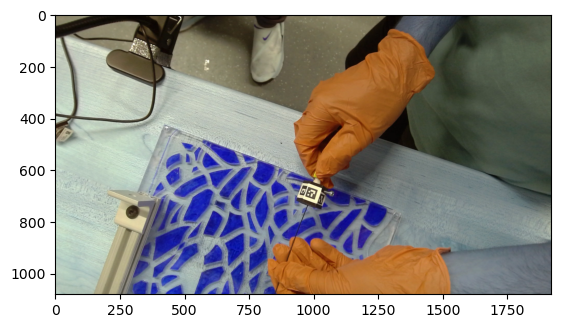

[(array([[[1031.,  734.],
          [1017.,  728.],
          [1028.,  692.],
          [1043.,  699.]]], dtype=float32),
  array([[[1005.,  714.],
          [ 969.,  703.],
          [ 980.,  667.],
          [1016.,  679.]]], dtype=float32),
  array([[[959., 662.],
          [976., 664.],
          [964., 698.],
          [947., 696.]]], dtype=float32)),
 array([[3],
        [4],
        [1]], dtype=int32),
 array([[[-0.41566626,  2.0403702 ,  0.05756763]],
 
        [[-0.48043935,  3.18427604,  0.15725919]],
 
        [[-2.51400713, -0.39901113, -1.4668076 ]]]),
 array([[[9.34329195e-02, 2.07069049e-01, 1.92358517e+00]],
 
        [[4.27099317e-02, 1.74467216e-01, 1.89747694e+00]],
 
        [[1.89268546e-03, 1.66974752e-01, 1.97751690e+00]]])]

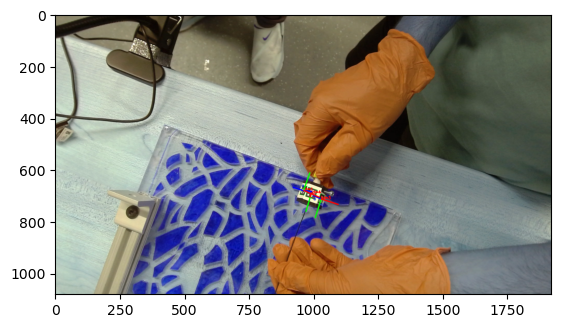

In [54]:
SESSION_ROOT = "/mnt/e/Workspace/CathederTelesurgery/Data/Datasets/ArucoVideo-6-28"
CUR_SESSION = "1-clip0"
test_img = cv2.imread(f"{SESSION_ROOT}/{CUR_SESSION}/frame0001.jpg")
test_result_img, *test_img_dets = aruco_single(test_img, pattern=cv2.aruco.DICT_4X4_1000, camera_intrinsics=camera_intrinsics)
# plt.subplot(1, 2, 1)
plt.imshow(test_img)
plt.show()
# plt.subplot(1, 2, 2)
plt.imshow(test_result_img)
test_img_dets

In [64]:
test_img_dets[2][1]

array([[-0.48043935,  3.18427604,  0.15725919]])

In [78]:
from tqdm import tqdm
import json
import numpyencoder

def track_through_frames(image_list, result_dir, pattern=aruco.DICT_5X5_250, camera_intrinsics=CameraIntrinsics(None, None)):
    if not os.path.exists(result_dir):
        os.makedirs(result_dir)
    for i, file in tqdm(enumerate(image_list)):
        detected = []
        result_img, corners, ids, rvecs, tvecs = aruco_single(cv2.imread(file), pattern=pattern, camera_intrinsics=camera_intrinsics)
        if result_img is None:
            result_img = cv2.imread(file)
            result_img = cv2.putText(result_img, "No markers detected", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 255), 2)
            cv2.imwrite(f"{result_dir}/frame{i:04d}.jpg", result_img)
            with open(f"{result_dir}/frame{i:04d}.json", 'w') as f:
                json.dump([], f, cls=numpyencoder.NumpyEncoder)
            continue
        for j in range(len(ids)):
            detected.append({
                'id': ids[j][0],
                'corners': corners[j],
                'rvec': rvecs[j,:,:].flatten(),
                'tvec': tvecs[j,:,:].flatten()
        })
        
        rvec_strings = [f"marker #{detected[i]['id']}: {detected[i]['rvec'].flatten()}" for i in range(len(detected))]
        cv2.putText(result_img, f"Rotations:", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 255), 2)
        for k, s in enumerate(rvec_strings):
            cv2.putText(result_img, s, (10, 40*(k+2)), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 255), 2)
        cv2.imwrite(f"{result_dir}/frame{i:04d}.jpg", result_img)

        with open(f"{result_dir}/frame{i:04d}.json", 'w') as f:
            json.dump(detected, f, cls=numpyencoder.NumpyEncoder)
    os.system(f"ffmpeg -framerate 15 -i {result_dir}/frame%04d.jpg -r 15 -b:v 20M {result_dir}/composite.mp4")



In [79]:
track_through_frames(
    image_list = [f"{SESSION_ROOT}/{CUR_SESSION}/{f}" for f in os.listdir(f"{SESSION_ROOT}/{CUR_SESSION}") if f.endswith('.jpg')], 
    result_dir = f"{SESSION_ROOT}/{CUR_SESSION}/aruco", 
    pattern=cv2.aruco.DICT_4X4_50, 
    camera_intrinsics=camera_intrinsics
)

312it [00:20, 15.10it/s]
ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/opt/conda/conda-bld/ffmpeg_1597178665428/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeh --cc=/opt/conda/conda-bld/ffmpeg_1597178665428/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0

In [80]:
CUR_SESSION = "1-clip1"
track_through_frames(
    image_list = [f"{SESSION_ROOT}/{CUR_SESSION}/{f}" for f in os.listdir(f"{SESSION_ROOT}/{CUR_SESSION}") if f.endswith('.jpg')], 
    result_dir = f"{SESSION_ROOT}/{CUR_SESSION}/aruco", 
    pattern=cv2.aruco.DICT_4X4_50, 
    camera_intrinsics=camera_intrinsics
)

360it [00:24, 14.48it/s]
ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/opt/conda/conda-bld/ffmpeg_1597178665428/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeh --cc=/opt/conda/conda-bld/ffmpeg_1597178665428/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0

In [83]:
CUR_SESSION = "2-clip0"
track_through_frames(
    image_list = [f"{SESSION_ROOT}/{CUR_SESSION}/{f}" for f in os.listdir(f"{SESSION_ROOT}/{CUR_SESSION}") if f.endswith('.jpg')], 
    result_dir = f"{SESSION_ROOT}/{CUR_SESSION}/aruco", 
    pattern=cv2.aruco.DICT_APRILTAG_16h5, 
    camera_intrinsics=camera_intrinsics
)

312it [00:21, 14.24it/s]
ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/opt/conda/conda-bld/ffmpeg_1597178665428/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeh --cc=/opt/conda/conda-bld/ffmpeg_1597178665428/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0

In [85]:
CUR_SESSION = "2-clip1"
track_through_frames(
    image_list = [f"{SESSION_ROOT}/{CUR_SESSION}/{f}" for f in os.listdir(f"{SESSION_ROOT}/{CUR_SESSION}") if f.endswith('.jpg')], 
    result_dir = f"{SESSION_ROOT}/{CUR_SESSION}/aruco", 
    pattern=cv2.aruco.DICT_APRILTAG_16h5, 
    camera_intrinsics=camera_intrinsics
)

960it [01:03, 15.00it/s]
ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/opt/conda/conda-bld/ffmpeg_1597178665428/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeh --cc=/opt/conda/conda-bld/ffmpeg_1597178665428/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0